# Important! 
When initially opening the notebook there should be a text to the right of the "Help" menu saying "Changes will not be saved". 
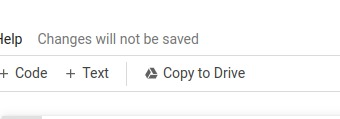

To ensure you can make changes to the notebook save a copy of it to your own drive and work on that one. You can do that by going to "File" -> "Save a copy in Drive".

**Failing to do so will result in code loss!**

 **Note** Make sure you are the only one that has access to it!


In [ ]:
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


###Version 1.2 - Last Update 10.01.2021
**Changelog:** 
* Changed the `effect_of_depth` section as per the updated PDF

**Version 1.1 - 07.01.2021 Changelog:** 
* Added tensorflow version code block

In [ ]:
#@markdown #Image Processing - 67829. { display-mode: "form" }
#@markdown ##Exercise 5: Neural Networks for Image Restoration
#@markdown ##Due date: 21.01.2021 at 23:59
#@title{ display-mode: "form" }
#@markdown Please enter your cs username:
cs_id = "avinoam" #@param {type:"string"}
#@markdown **Make sure the username you typed is correct before you proceed.**
#@markdown
#@markdown
#@markdown This exercise deals with neural networks and their application to image restoration.
#@markdown In this exercise you will develop a general workflow for training networks to restore corrupted images,
#@markdown and then apply this workflow on two different tasks: (i) image denoising, and (ii) image deblurring.
#@markdown
#@markdown
#@markdown Before you start working on the exercise it is recommended that you review the lecture slides covering neural networks,
#@markdown and how to implement them using the Keras framework. To recap the relevant part of the lecture: there are many possible
#@markdown ways to use neural networks for image restoration.
#@markdown
#@markdown The method you will implement consists of the following three steps:
#@markdown
#@markdown 1. Collect "clean" images, apply simulated random corruptions, and extract small patches.
#@markdown 2. Train a neural network to map from corrupted patches to clean patches.
#@markdown 3. Given a corrupted image, use the trained network to restore the complete image by restoring each patch separately, by applying the "ConvNet Trick" for approximating this process as learned in class.
#@markdown 
#@markdown **NOTE**: Neural networks are typically trained on GPUs, without GPUs training takes much longer. 
#@markdown To enable GPU tranining click on "Runtime" -> "Change runtime type" -> "GPU" -> "SAVE".

#@markdown **NOTE**: A short guide on debugging your code using colab is availble [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=qnIn-rWFqoww).

#@markdown But first, we have to download the dataset. Play this cell to download it and get everything ready.
#@markdown This may take a few minutes.

 



import re
import os,itertools, random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.draw import line

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json

from imageio import imread
from skimage.color import rgb2gray
from tensorflow.keras.layers import Input, Conv2D, Activation, Add, UpSampling2D, Dense, Flatten, Reshape, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from skimage import color



########## Register student ID ##########

# regex=re.compile(r'^\d+$')
# assert regex.match(id_num), "Please write your ID number in the corresponding field"
# with open(f"{id_num}.json", "w") as write_file:
#     json.dump({}, write_file)

# def write_json(key, values):
#   r=np.random.randint(1e7)
#   values.update({"r":r})
#   with open(f"{id_num}.json", "r") as file:
#     data = json.load(file)
#   if key in data.keys():
#     for k, v in values.items():
#       data[key][k].append(v)
#   else:
#     data[key] = {k:[v] for k, v in values.items()}
#   with open(f"{id_num}.json", "w") as file:
#     json.dump(data, file)

########## End of register student ID ##########

########## Utils ##########

def relpath(path):
    """Returns the relative path to the script's location

    Arguments:
    path -- a string representation of a path.
    """
    return os.path.join(os.getcwd(), path)


def list_images(path, use_shuffle=True):
    """Returns a list of paths to images found at the specified directory.

    Arguments:
    path -- path to a directory to search for images.
    use_shuffle -- option to shuffle order of files. Uses a fixed shuffled order.
    """

    def is_image(filename):
        return os.path.splitext(filename)[-1][1:].lower() in ['jpg', 'png']

    images = list(map(lambda x: os.path.join(path, x), filter(is_image, os.listdir(path))))
    # Shuffle with a fixed seed without affecting global state
    if use_shuffle:
        s = random.getstate()
        random.seed(1234)
        random.shuffle(images)
        random.setstate(s)
    return images


def images_for_denoising():
    """Returns a list of image paths to be used for image denoising in Ex5"""
    return list_images(relpath("current/image_dataset/train"), True)


def images_for_deblurring():
    """Returns a list of image paths to be used for text deblurring in Ex5"""
    return list_images(relpath("current/text_dataset/train"), True)


def images_for_super_resolution():
    """Returns a list of image paths to be used for image super-resolution in Ex5"""
    return list_images(relpath("current/image_dataset/train"), True)


def motion_blur_kernel(kernel_size, angle):
    """Returns a 2D image kernel for motion blur effect.

    Arguments:
    kernel_size -- the height and width of the kernel. Controls strength of blur.
    angle -- angle in the range [0, np.pi) for the direction of the motion.
    """
    if kernel_size % 2 == 0:
        raise ValueError('kernel_size must be an odd number!')
    if angle < 0 or angle > np.pi:
        raise ValueError('angle must be between 0 (including) and pi (not including)')
    norm_angle = 2.0 * angle / np.pi
    if norm_angle > 1:
        norm_angle = 1 - norm_angle
    half_size = kernel_size // 2
    if abs(norm_angle) == 1:
        p1 = (half_size, 0)
        p2 = (half_size, kernel_size - 1)
    else:
        alpha = np.tan(np.pi * 0.5 * norm_angle)
        if abs(norm_angle) <= 0.5:
            p1 = (2 * half_size, half_size - int(round(alpha * half_size)))
            p2 = (kernel_size - 1 - p1[0], kernel_size - 1 - p1[1])
        else:
            alpha = np.tan(np.pi * 0.5 * (1 - norm_angle))
            p1 = (half_size - int(round(alpha * half_size)), 2 * half_size)
            p2 = (kernel_size - 1 - p1[0], kernel_size - 1 - p1[1])
    rr, cc = line(p1[0], p1[1], p2[0], p2[1])
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float64)
    kernel[rr, cc] = 1.0
    kernel /= kernel.sum()
    return kernel


def read_image(filename, representation):
    """Reads an image, and if needed makes sure it is in [0,1] and in float64.
    arguments:
    filename -- the filename to load the image from.
    representation -- if 1 convert to grayscale. If 2 keep as RGB.
    """
    im = imread(filename)
    if representation == 1 and im.ndim == 3 and im.shape[2] == 3:
        im = color.rgb2gray(im).astype(np.float64)
    if im.dtype == np.uint8:    
        im = im.astype(np.float64) / 255.0
    return im
########## End of utils ##########

########## Download datasets ##########

!mkdir current
%cd current
!wget --load-cookies /tmp/cookies.txt "https://www.cs.huji.ac.il/~impr/datasets.tar" -O datasets.tar && rm -rf /tmp/cookies.txt
!tar -xvf datasets.tar
!unzip image_dataset.zip
!unzip text_dataset.zip
!rm -f datasets.tar
!rm -f image_dataset.zip
!rm -f text_dataset.zip
%cd ..
!wget --load-cookies /tmp/cookies.txt "https://www.cs.huji.ac.il/~impr/requirements.txt" -O requirements.txt && rm -rf /tmp/cookies.txt
!pip install -r requirements.txt

########## End of download datasets ##########


mkdir: cannot create directory ‘current’: File exists
/content/current
Cannot open cookies file ‘/tmp/cookies.txt’: No such file or directory
--2021-01-24 18:22:03--  https://www.cs.huji.ac.il/~impr/datasets.tar
Resolving www.cs.huji.ac.il (www.cs.huji.ac.il)... 132.65.118.16
Connecting to www.cs.huji.ac.il (www.cs.huji.ac.il)|132.65.118.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98600960 (94M) [application/x-tar]
Saving to: ‘datasets.tar’

datasets.tar        100%[===================>]  94.03M  15.3MB/s    in 7.3s    

2021-01-24 18:22:12 (12.8 MB/s) - ‘datasets.tar’ saved [98600960/98600960]

text_dataset.zip
image_dataset.zip
Archive:  image_dataset.zip
replace image_dataset/train/100075.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  text_dataset.zip
replace text_dataset/train/0000005_orig.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content
Cannot open cookies file ‘/tmp/cookies.txt’: No such file or directory
--2021-01-24 18:22:18--  http

# 3 Dataset Handling

In [ ]:
def load_dataset(filenames, batch_size, corruption_func, crop_size):
    """
    A generator for generating pairs of image patches, corrupted and original
    :param filenames: a list of filenames of clean images.
    :param batch_size: The size of the batch of images for each iteration of Stochastic Gradient Descent.
    :param corruption_func: A function receiving a numpy array representation of an image as a single argument, and returning a randomly corrupted version of the input image.
    :param crop_size: A tuple (height, width) specifying the crop size of the patches to extract.
    :return:outputs random tuples of the form (source_batch, target_batch), where each output variable is an array of shape(batch_size, height, width, 1).
     target_batch is made of clean images and source_batch is their respective randomly corrupted version
     according to corruption_func(im)
    """
    import numpy.random
    images_dict = {}
    while(True):
        file_names = np.random.choice(filenames,np.int64(batch_size))
        original_patches = []
        corrupted_patches = []
        for file in file_names:
            if(file in images_dict):
                im = images_dict[file]
            else:
                im = read_image(file,1)
                images_dict[file] = im
            if((crop_size[0] * 3 < im.shape[0]) and (crop_size[1] * 3 < im.shape[1])):
                #optimized cropping
                im_height = im.shape[0]
                im_width = im.shape[1]
                largest_possible_large_crop_height_start = np.random.randint(0, im_height - (crop_size[0]*3) + 1)
                largest_possible_large_crop_width_start = np.random.randint(0, im_width - (crop_size[1]*3) + 1)
                large_crop = im[largest_possible_large_crop_height_start:largest_possible_large_crop_height_start + (crop_size[0] * 3),
                                           largest_possible_large_crop_width_start:largest_possible_large_crop_width_start + (crop_size[1] * 3)]
                corrupted_large_crop = corruption_func(large_crop)
                large_crop_height = large_crop.shape[0]
                large_crop_width = large_crop.shape[1]
                largest_possible_start_of_height_crop = np.random.randint(0, large_crop_height - crop_size[0] + 1)
                largest_possible_start_of_width_crop = np.random.randint(0, large_crop_width - crop_size[1] + 1)
                crop_from_original_image = large_crop[
                                           largest_possible_start_of_height_crop:largest_possible_start_of_height_crop +
                                                                                 crop_size[0],
                                           largest_possible_start_of_width_crop:largest_possible_start_of_width_crop +
                                                                                crop_size[1]] 
                crop_from_corrupted_image = corrupted_large_crop[
                                            largest_possible_start_of_height_crop:largest_possible_start_of_height_crop +
                                                                                  crop_size[0],
                                            largest_possible_start_of_width_crop:largest_possible_start_of_width_crop +
                                                                                 crop_size[1]] 

                crop_from_original_image = crop_from_original_image - 0.5
                crop_from_corrupted_image = crop_from_corrupted_image - 0.5
                original_patches.append(crop_from_original_image)
                corrupted_patches.append(crop_from_corrupted_image)
            else:
                corrupted = corruption_func(im)
                im_height = im.shape[0]
                im_width = im.shape[1]
                largest_possible_start_of_height_crop = np.random.randint(0,im_height - crop_size[0] + 1)
                largest_possible_start_of_width_crop = np.random.randint(0, im_width - crop_size[1] + 1)
                crop_from_original_image = im[largest_possible_start_of_height_crop:largest_possible_start_of_height_crop + crop_size[0],
                                           largest_possible_start_of_width_crop:largest_possible_start_of_width_crop + crop_size[1]]
                crop_from_corrupted_image = corrupted[largest_possible_start_of_height_crop:largest_possible_start_of_height_crop + crop_size[0],
                                           largest_possible_start_of_width_crop:largest_possible_start_of_width_crop + crop_size[1]] 
                crop_from_original_image = crop_from_original_image - 0.5
                crop_from_corrupted_image = crop_from_corrupted_image - 0.5
                original_patches.append(crop_from_original_image)
                corrupted_patches.append(crop_from_corrupted_image)
                # plt.imshow(crop_from_original_image)
                # plt.show()
                # print(crop_from_original_image)
                # plt.imshow(crop_from_corrupted_image)
                # plt.show()
                # print(crop_from_corrupted_image)

        original_patches = np.array((original_patches)).reshape((batch_size,crop_size[0],crop_size[1],1))
        corrupted_patches = np.array((corrupted_patches)).reshape((batch_size,crop_size[0],crop_size[1],1))
        yield (corrupted_patches,original_patches)

# 4 Neural Network Model

In [ ]:
def resblock(input_tensor, num_channels):
    """
    Takes as input a symbolic input tensor and the number of channels for each of its convolutional layers, and returns the symbolic output tensor of the resnet block.
    The convolutional layers should use “same” border mode, so as to not decrease the spatial dimension of the output tensor.
    :param input_tensor: input tensor
    :param num_channels: number of channels
    :return: symbolic output tensor of the resnet block
    """
    from tensorflow.keras.layers import Conv2D, Activation, Add
    after_conv_1 = Conv2D(num_channels,(3,3),padding='same')(input_tensor)
    after_relu_1 = Activation('relu')(after_conv_1)
    after_conv_2 = Conv2D(num_channels,(3,3),padding='same')(after_relu_1)
    after_add = Add()([input_tensor,after_conv_2])
    after_relu_2 = Activation('relu')(after_add)
    return after_relu_2

In [ ]:
def build_nn_model(height, width, num_channels, num_res_blocks):
    """
    Create an untrained Keras model with input dimension the shape of (height, width, 1), and all convolutional layers (including residual
    blocks) with number of output channels equal to num_channels, except the very last convolutional layer which should have a single output channel.
    The number of residual blocks should be equal to num_res_blocks.
    :param height: height
    :param width: width
    :param num_channels: number of channels
    :param num_res_blocks: number of residual blocks
    :return: an untrained Keras model.
    """
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv2D, Activation, Add
    model_input = Input(shape=(height, width, 1))
    after_conv_1 = Conv2D(num_channels,(3,3),padding='same')(model_input)
    after_relu_1 = Activation('relu')(after_conv_1)
    temp = after_relu_1
    for i in range(0, num_res_blocks):
        temp =  resblock(temp,num_channels)
    after_conv_2 = Conv2D(1,(3,3),padding='same')(temp)
    after_add = Add()([model_input,after_conv_2])
    model = Model(inputs=model_input, outputs=after_add)
    return model

# 5 Training Networks for Image Restoration

In [ ]:
def train_model(model, images, corruption_func, batch_size, steps_per_epoch, num_epochs, num_valid_samples):
    """
    Divide the images into a training set and validation set, using an 80-20 split, and generate from each set a dataset with the given batch size
    and corruption function. Eventually it will train the model.
    :param model:  a general neural network model for image restoration.
    :param images: a list of file paths pointing to image files. You should assume these paths are complete, and should append anything to them.
    :param corruption_func: a corruption function.
    :param batch_size: the size of the batch of examples for each iteration of SGD.
    :param steps_per_epoch: the number of update steps in each epoch.
    :param num_epochs: the number of epochs for which the optimization will run.
    :param num_valid_samples: the number of samples in the validation set to test on after every epoch.
    """
    from tensorflow.keras.optimizers import Adam
    training_set = images[:np.int64(len(images) * 0.8)]
    validation_set = images[np.int64(len(images) * 0.8):]
    dataset_from_training_generator = load_dataset(training_set,batch_size,corruption_func,(model.input_shape[1],model.input_shape[2]))
    dataset_from_validation_generator = load_dataset(validation_set,batch_size,corruption_func,(model.input_shape[1],model.input_shape[2]))
    model.compile(loss='mean_squared_error',optimizer=Adam(beta_2=0.9))
    hist = model.fit_generator(dataset_from_training_generator,steps_per_epoch=steps_per_epoch,epochs=num_epochs,validation_data=dataset_from_validation_generator,validation_steps=np.int32(num_valid_samples / batch_size),use_multiprocessing = True, workers=1)

# 6 Image Restoration of Complete Images

In [ ]:
def restore_image(corrupted_image, base_model):
    """
    Restore full images of any size
    :param corrupted_image: a grayscale image of shape (height, width) and with values in the [0, 1] range of type float64 that is affected
    by a corruption generated from the same corruption function encountered during training (the image is not necessarily from the training set though).
    :param base_model: a neural network trained to restore small patches. The input and output of the network are images with values in the [−0.5, 0.5] range.
    :return: the restored image
    """
    a = Input(shape=(corrupted_image.shape[0], corrupted_image.shape[1], 1))  # with width and height of the image to be restored.
    b = base_model(a)
    new_model = Model(inputs=a, outputs=b)
    minus_half_corrupted = (corrupted_image - 0.5).reshape((corrupted_image.shape[0],corrupted_image.shape[1],1))
    prediction = new_model.predict(np.array([minus_half_corrupted]))[0] + 0.5
    return np.squeeze(np.clip(prediction,0,1)).astype(np.float64)

In [ ]:
# image = read_image("https://image.freepik.com/free-vector/christmas-composition-paper-cut-style-sale-banner-background_255246-1232.jpg",1)
# corruption_func = lambda x: x 
# corrupted = corruption_func(image)
# # plt.imshow(image)
# # plt.imshow(corrupted)

# 7 Application to Image Denoising and Deblurring
## 7.1 Image Denoising
### 7.1.1 Gaussian Noise

In [ ]:
def add_gaussian_noise(image, min_sigma, max_sigma):
    """
    Add random gaussian noise to an image
    :param image: a grayscale image with values in the [0, 1] range of type float64.
    :param min_sigma: a non-negative scalar value representing the minimal variance of the gaussian distribution.
    :param max_sigma: a non-negative scalar value larger than or equal to min_sigma, representing the maximal variance of the gaussian distribution
    :return: the corrupted image
    """
    from numpy import random
    picked_sigma = np.random.uniform(min_sigma, max_sigma)
    noise_to_add = np.random.normal(0,picked_sigma,image.shape)
    new_image = image + noise_to_add
    new_image = (new_image * 255.0)
    new_image = np.around(new_image) / 255.0
    return np.clip(new_image,0,1)

In [ ]:
def corruption_func_gaussian(image):
    return add_gaussian_noise(image,0,0.2)

In [ ]:
#@markdown ### 7.1.2 Training a Denoising Mode

denoise_num_res_blocks = 7 #@param {type:"slider", min:1, max:15, step:1}
#@markdown **DON'T FORGET TO RUN THIS CELL AFTER CHANGING IT!**


In [ ]:
def learn_denoising_model(denoise_num_res_blocks, quick_mode=False):
    """
    Train a denoising model
    :param denoise_num_res_blocks: number of residual blocks
    :param quick_mode: is quick mode
    :return: the trained model
    """
    image_set = images_for_denoising()
    model = build_nn_model(24,24,48,denoise_num_res_blocks)
    # print(denoise_num_res_blocks)
    if(quick_mode):
        train_model(model, image_set, corruption_func_gaussian, 10, 3, 2, 30)
    else:
        train_model(model,image_set,corruption_func_gaussian,100,100,10,1000)
    return model

Exception reporting mode: Verbose
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


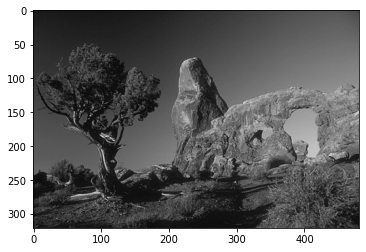

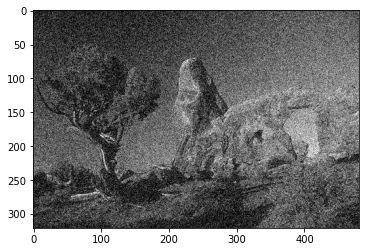

1
Epoch 1/10
100/100 [==============================] - 16s 158ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 2/10
100/100 [==============================] - 7s 72ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 3/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 4/10
100/100 [==============================] - 7s 72ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 5/10
100/100 [==============================] - 7s 72ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/10
100/100 [==============================] - 7s 72ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 7/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 8/10
100/100 [==============================] - 7s 71ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/10
100/100 [==============================] - 7s 72ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/10
100/100 [==============================] - 7s 72ms/step - loss: 0.0022 - va

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

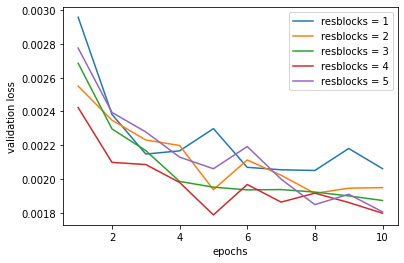

In [ ]:
# %xmode Verbose
# from google.colab import drive, files
# from tensorflow.keras.models import load_model
# import os
# drive.mount('/content/drive')

# # trained = learn_denoising_model(denoise_num_res_blocks,True)
# # trained.save(os.getcwd() + "denoise.h5")
# # files.download(os.getcwd() + "denoise.h5")
# im = read_image(images_for_denoising()[0],1)
# plt.imshow(im,cmap='gray')
# plt.show()
# corrupted = corruption_func_gaussian(im)
# plt.imshow(corrupted,cmap='gray')
# plt.show()

# for i in range(1,6):
#   trained = learn_denoising_model(i,False)
#   # plt.plot([1,2,3,4,5,6,7,8,9,10], trained.history.history['val_loss'], label="resblocks = " + str(i))
#   new_im = restore_image(corrupted.reshape((corrupted.shape[0],corrupted.shape[1],1)),trained)
#   new_im = new_im.reshape((new_im.shape[0],new_im.shape[1]))
#   plt.imshow(new_im,cmap='gray')
#   plt.show()
#   # plt.plot([1,2], trained.history.history['val_loss'], label="resblocks = " + str(i))

# # plt.ylabel('validation loss')
# # plt.xlabel('epochs')
# # plt.legend()
# # # plt.show()
# # plt.savefig(os.getcwd() + 'denoise_graph.png')
# # files.download(os.getcwd() + "denoise_graph.png")

In [ ]:
# %xmode Verbose
# from google.colab import drive, files
# from tensorflow.keras.models import load_model
# import os
# drive.mount('/content/drive')

# trained = learn_denoising_model(denoise_num_res_blocks,False)
# trained.save(os.getcwd() + "denoise.h5")
# files.download(os.getcwd() + "denoise.h5")


Exception reporting mode: Verbose
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
7
Epoch 1/10
100/100 [==============================] - 15s 149ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 3/10
100/100 [==============================] - 11s 107ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/10
100/100 [==============================] - 11s 107ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 5/10
100/100 [==============================] - 11s 107ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 6/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/10
100/100 [==============================] - 11s 107ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 9/10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

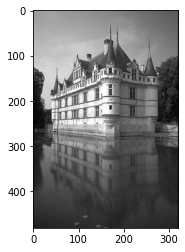

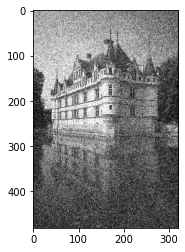

0.00018187981358955366
-0.003418433111642927


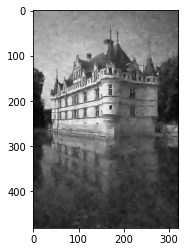

In [ ]:
# trained = load_model(os.getcwd() + "denoise.h5")
# im = read_image(images_for_denoising()[45],1)
# plt.imshow(im,cmap='gray')
# plt.show()
# corrupted = corruption_func_gaussian(im)
# plt.imshow(corrupted,cmap='gray')
# plt.show()
# print(np.mean(im - corrupted))
# new_im = restore_image(corrupted.reshape((corrupted.shape[0],corrupted.shape[1],1)),trained)
# new_im = new_im.reshape((new_im.shape[0],new_im.shape[1]))
# print(np.mean(im - new_im))
# plt.imshow(new_im,cmap='gray')
# plt.show()

## 7.2 Image Deblurring
### 7.2.1 Motion Blur

In [ ]:
def add_motion_blur(image, kernel_size, angle):
    """
    Simulate motion blur on the given image using a square kernel of size kernel_size where the line has the given angle in radians, measured relative to the positive horizontal axis.
    :param image: a grayscale image with values in the [0, 1] range of type float64.
    :param kernel_size:  an odd integer specifying the size of the kernel.
    :param angle: an angle in radians in the range [0, π).
    :return: blurred image
    """
    mb_kernel = motion_blur_kernel(kernel_size,angle)
    blurred_image = convolve(image,mb_kernel)
    return blurred_image

In [ ]:
def random_motion_blur(image, list_of_kernel_sizes):
    """
    Simulate motion blur on the given image using a square kernel of size kernel_size where the line has the given angle in radians, measured relative to the positive horizontal axis.
    :param image: a grayscale image with values in the [0, 1] range of type float64.
    :param list_of_kernel_sizes: a list of odd integers.
    :return: blurred image
    """
    picked_angle = np.random.uniform(0, np.pi)
    picked_size = np.random.choice(list_of_kernel_sizes)
    new_image = add_motion_blur(image,picked_size,picked_angle)
    # im_min = np.min(new_image)
    # im_max = np.max(new_image)
    # new_image = ((new_image - im_min) / np.float32((im_max - im_min)))
    new_image = np.around(new_image * 255.0)
    new_image = new_image / 255.0
    return np.clip(new_image.astype(np.float64), 0, 1)

In [ ]:
def corruption_func_motion_blur(image):
    return random_motion_blur(image, [7])

In [ ]:
#@markdown ### 7.2.2 Training a Deblurring Model


deblur_num_res_blocks = 7 #@param {type:"slider", min:1, max:15, step:1}

#@markdown **DON'T FORGET TO RUN THIS CELL AFTER YOU CHANGING THE VALUE!**

In [ ]:
def learn_deblurring_model(deblur_num_res_blocks, quick_mode=False):
    """
    Train a deblurring model
    :param deblur_num_res_blocks: number of residual blocks
    :param quick_mode: is quick mode
    :return: the trained model
    """
    image_set = images_for_deblurring()
    model = build_nn_model(16, 16, 32, deblur_num_res_blocks)
    if (quick_mode):
        train_model(model, image_set, corruption_func_motion_blur, 10, 3, 2, 30)
    else:
        train_model(model, image_set, corruption_func_motion_blur, 100, 100, 10, 1000)
    return model

Exception reporting mode: Verbose
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0236 - val_loss: 0.0224
Epoch 2/10
100/100 [==============================] - 6s 59ms/step - loss: 0.0193 - val_loss: 0.0183
Epoch 3/10
100/100 [==============================] - 6s 59ms/step - loss: 0.0173 - val_loss: 0.0166
Epoch 4/10
100/100 [==============================] - 6s 59ms/step - loss: 0.0166 - val_loss: 0.0172
Epoch 5/10
100/100 [==============================] - 6s 59ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 6/10
100/100 [==============================] - 6s 60ms/step - loss: 0.0150 - val_loss: 0.0156
Epoch 7/10
100/100 [==============================] - 6s 60ms/step - loss: 0.0146 - val_loss: 0.0149
Epoch 8/10
100/100 [==============================] - 6s 60ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 9/10
100/100 [=======

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

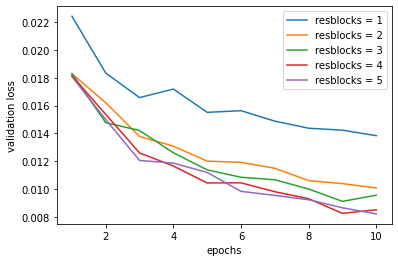

In [ ]:
# %xmode Verbose
# from google.colab import drive, files
# from tensorflow.keras.models import load_model
# import os
# drive.mount('/content/drive')

# # trained = learn_deblurring_model(deblur_num_res_blocks,False)
# # trained.save(os.getcwd() + "deblur.h5")
# # files.download(os.getcwd() + "deblur.h5")

# for i in range(1,6):
#   trained = learn_deblurring_model(i,False)
#   plt.plot([1,2,3,4,5,6,7,8,9,10], trained.history.history['val_loss'], label="resblocks = " + str(i))
#   # plt.plot([1,2], trained.history.history['val_loss'], label="resblocks = " + str(i))

# plt.ylabel('validation loss')
# plt.xlabel('epochs')
# plt.legend()
# # plt.show()
# plt.savefig(os.getcwd() + 'deblur_graph.png')
# files.download(os.getcwd() + "deblur_graph.png")

Exception reporting mode: Verbose
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


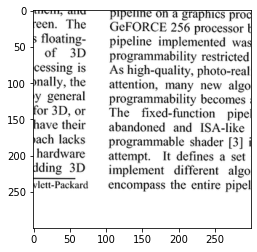

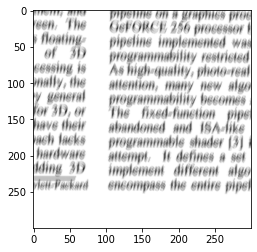

0.875658954248366
0.8756835729847495
Epoch 1/10
100/100 [==============================] - 15s 151ms/step - loss: 0.0227 - val_loss: 0.0214
Epoch 2/10
100/100 [==============================] - 6s 60ms/step - loss: 0.0184 - val_loss: 0.0166
Epoch 3/10
100/100 [==============================] - 6s 62ms/step - loss: 0.0166 - val_loss: 0.0162
Epoch 4/10
100/100 [==============================] - 6s 61ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 5/10
100/100 [==============================] - 6s 62ms/step - loss: 0.0149 - val_loss: 0.0154
Epoch 6/10
100/100 [==============================] - 6s 61ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 7/10
100/100 [==============================] - 6s 59ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 8/10
100/100 [==============================] - 6s 61ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 9/10
100/100 [==============================] - 6s 61ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 10/10
100/100 [==============================]

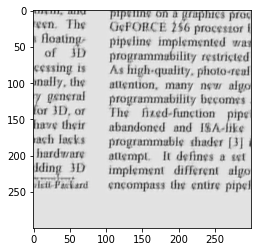

0.8797172
-2.461873638343606e-05
-0.0040583121281160955
Epoch 1/10
100/100 [==============================] - 16s 157ms/step - loss: 0.0220 - val_loss: 0.0184
Epoch 2/10
100/100 [==============================] - 7s 66ms/step - loss: 0.0165 - val_loss: 0.0154
Epoch 3/10
100/100 [==============================] - 6s 65ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 4/10
100/100 [==============================] - 6s 64ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 5/10
100/100 [==============================] - 6s 64ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 6/10
100/100 [==============================] - 6s 64ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 7/10
100/100 [==============================] - 6s 65ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 8/10
100/100 [==============================] - 6s 65ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 9/10
100/100 [==============================] - 6s 63ms/step - loss: 0.0104 - val_loss: 0.0111
Epoch 10/10
100/100 [============

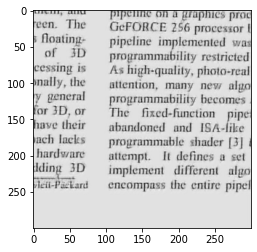

0.87082493
-2.461873638343606e-05
0.004834010302560787
Epoch 1/10
100/100 [==============================] - 16s 163ms/step - loss: 0.0218 - val_loss: 0.0174
Epoch 2/10
100/100 [==============================] - 6s 63ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 3/10
100/100 [==============================] - 7s 66ms/step - loss: 0.0138 - val_loss: 0.0135
Epoch 4/10
100/100 [==============================] - 6s 65ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 5/10
100/100 [==============================] - 7s 66ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 6/10
100/100 [==============================] - 6s 64ms/step - loss: 0.0107 - val_loss: 0.0107
Epoch 7/10
100/100 [==============================] - 6s 64ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 8/10
100/100 [==============================] - 7s 65ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 9/10
100/100 [==============================] - 7s 66ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 10/10
100/100 [=============

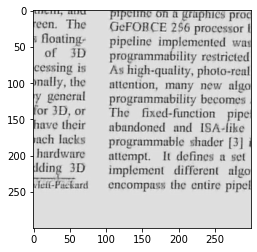

0.8733073
-2.461873638343606e-05
0.002351684700651892
Epoch 1/10
100/100 [==============================] - 17s 167ms/step - loss: 0.0221 - val_loss: 0.0174
Epoch 2/10
100/100 [==============================] - 7s 66ms/step - loss: 0.0153 - val_loss: 0.0150
Epoch 3/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 4/10
100/100 [==============================] - 7s 66ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 5/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 6/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 7/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 8/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 9/10
100/100 [==============================] - 7s 66ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 10/10
100/100 [==============

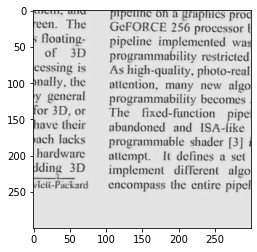

0.8708552
-2.461873638343606e-05
0.004803721943037968
Epoch 1/10
100/100 [==============================] - 17s 172ms/step - loss: 0.0224 - val_loss: 0.0174
Epoch 2/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0149 - val_loss: 0.0139
Epoch 3/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 4/10
100/100 [==============================] - 7s 70ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 5/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 6/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0096 - val_loss: 0.0091
Epoch 7/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0090 - val_loss: 0.0097
Epoch 8/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 9/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 10/10
100/100 [==============

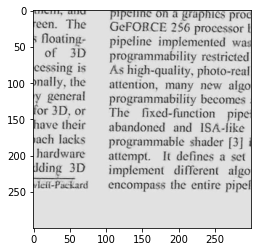

0.87317413
-2.461873638343606e-05
0.002484777947138344


In [ ]:
# %xmode Verbose
# from google.colab import drive, files
# from tensorflow.keras.models import load_model
# import os
# drive.mount('/content/drive')
# im = read_image(images_for_deblurring()[2],1)
# plt.imshow(im,cmap='gray')
# plt.show()
# corrupted = corruption_func_motion_blur(im)
# plt.imshow(corrupted,cmap='gray')
# plt.show()


# print(np.mean(im))
# print(np.mean(corrupted))



# for i in range(1,6):
#   trained = learn_deblurring_model(i,False)
#   new_im = restore_image(corrupted.reshape((corrupted.shape[0],corrupted.shape[1],1)),trained)
#   new_im = new_im.reshape((new_im.shape[0],new_im.shape[1]))
#   plt.imshow(new_im,cmap='gray')
#   plt.show()
#   print(np.mean(new_im))
#   print(np.mean(im - corrupted))
#   print(np.mean(im - new_im))



In [ ]:
# %xmode Verbose
# from google.colab import drive, files
# from tensorflow.keras.models import load_model
# import os
# drive.mount('/content/drive')

# trained = learn_deblurring_model(deblur_num_res_blocks,False)
# trained.save(os.getcwd() + "deblur.h5")
# files.download(os.getcwd() + "deblur.h5")

Exception reporting mode: Verbose
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
100/100 [==============================] - 15s 153ms/step - loss: 0.0241 - val_loss: 0.0185
Epoch 2/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 3/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 4/10
100/100 [==============================] - 7s 66ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 5/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 6/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 7/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 8/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 9/10
100/100 [=======

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

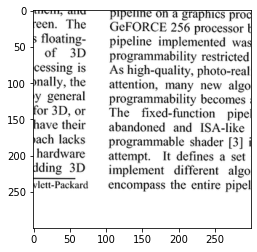

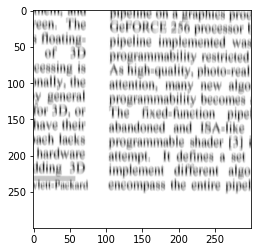

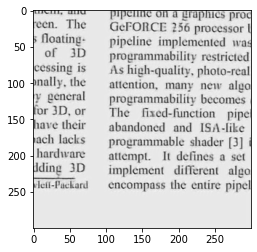

0.875658954248366
0.875696688453159
0.87173826
-3.773420479302148e-05
0.003920645027893048


In [ ]:
# trained = load_model(os.getcwd() + "deblur.h5")
# im = read_image(images_for_deblurring()[2],1)
# plt.imshow(im,cmap='gray')
# plt.show()
# corrupted = corruption_func_motion_blur(im)
# plt.imshow(corrupted,cmap='gray')
# plt.show()


# new_im = restore_image(corrupted.reshape((corrupted.shape[0],corrupted.shape[1],1)),trained)
# new_im = new_im.reshape((new_im.shape[0],new_im.shape[1]))
# plt.imshow(new_im,cmap='gray')
# plt.show()
# print(np.mean(im))
# print(np.mean(corrupted))
# print(np.mean(new_im))
# print(np.mean(im - corrupted))
# print(np.mean(im - new_im))



# # new_im = im - new_im
# # new_im = new_im / new_im.max()
# # print(np.mean(im - new_im))
# # plt.imshow(new_im,cmap='gray')
# # plt.show()

##7.3 Image Super-resolution
### 7.3.1 Image Low-Resolution Corruption
**Note:** Make sure your implementation covers different LR scales, for simplicity you may assume we won't test your network on images which are of more than $4$ times lower in quality compared to the HR one.

**Hint:** The `scipy.ndimage.zoom` function may come in handy.


In [ ]:
def super_resolution_corruption(image):
    """
    Perform the super resolution corruption 
    :param image: a grayscale image with values in the [0, 1] range of type float64.
    :return: corrupted image
    """
    factor = np.random.randint(2,5)
    return super_resolution_corruption_with_min(image,factor)
      



In [ ]:
def super_resolution_corruption_with_min(image,min):
    """
    Perform the super resolution corruption 
    :param image: a grayscale image with values in the [0, 1] range of type float64.
    :return: corrupted image
    """
    from PIL import Image
    import PIL
    mode = "resize"
    from skimage.transform import resize
    import warnings
    factor = np.random.randint(min,5)
    if(mode == "resize"):
      image_resized = None
      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          image_small = zoom(image,np.float32(1.0/factor))
          image_resized = zoom(image_small,factor)
          image_p = Image.fromarray(image_resized)
          result = image_p.resize((np.int64(image.shape[1]),(np.int64(image.shape[0]))),resample = PIL.Image.BICUBIC)
          return np.array(np.clip(result,0,1)).astype(np.float64)
      # return resize(image_resized, (image.shape[0], image.shape[1]),mode='reflect',anti_aliasing=False)
    elif (mode == "resize"):
      image_p = Image.fromarray(image)
      image_resized_p = image_p.resize(((np.int64(image.shape[1] // factor),(np.int64(image.shape[0] // factor)))),resample = PIL.Image.NEAREST)
      result = image_resized_p.resize((np.int64(image.shape[1]),(np.int64(image.shape[0]))),resample = PIL.Image.NEAREST)
      return np.array(np.clip(result,0,1)).astype(np.float64)
      



In [ ]:
#@markdown ### 7.3.2 Training a Super Resolution Model


super_resolution_num_res_blocks = 10 #@param {type:"slider", min:1, max:15, step:1}
batch_size = 33 #@param {type:"slider", min:1, max:128, step:16}
steps_per_epoch = 300 #@param {type:"slider", min:100, max:5000, step:100}
num_epochs = 10 #@param {type:"slider", min:1, max:20, step:1}
patch_size = 20 #@param {type:"slider", min:8, max:32, step:2}
num_channels = 28 #@param {type:"slider", min:16, max:64, step:2}

#@markdown **DON'T FORGET TO RUN THIS CELL AFTER YOU CHANGING THE VALUES!**

In [ ]:
def learn_super_resolution_model(super_resolution_num_res_blocks, quick_mode=False):
    """
    Train a super resolution model
    :param super_resolution_num_res_blocks: number of residual blocks
    :param quick_mode: is quick mode
    :return: the trained model
    """
    image_set = images_for_super_resolution()
    model = build_nn_model(patch_size, patch_size, num_channels, super_resolution_num_res_blocks)
    if (quick_mode):
        train_model(model, image_set, super_resolution_corruption, 10, 3, 2, 30)
    else:
        train_model(model, image_set, super_resolution_corruption, batch_size, steps_per_epoch, num_epochs, 1000)
    return model

Exception reporting mode: Verbose
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
300/300 [==============================] - 49s 163ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 2/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 3/10
300/300 [==============================] - 15s 52ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 4/10
300/300 [==============================] - 15s 50ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 5/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 6/10
300/300 [==============================] - 16s 52ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 7/10
300/300 [==============================] - 15s 50ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 9/10
300/300 [

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

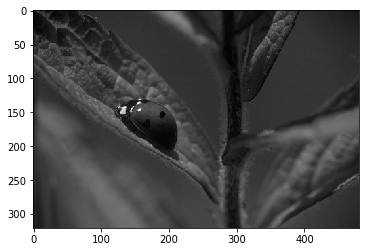

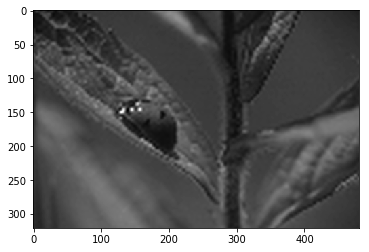

1.7301711415881123e-05
-0.00012687680917237813


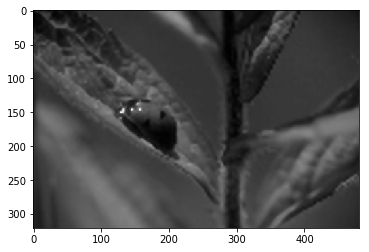

In [ ]:
# %xmode Verbose
# from google.colab import drive, files
# from tensorflow.keras.models import load_model
# import os
# drive.mount('/content/drive')


# trained = learn_super_resolution_model(super_resolution_num_res_blocks,False)
# trained.save(os.getcwd() + "superres.h5")
# files.download(os.getcwd() + "superres.h5")
# trained = load_model(os.getcwd() + "superres.h5")
# im = read_image(images_for_super_resolution()[2],1)
# plt.imshow(im,cmap='gray')
# plt.show()
# corrupted = super_resolution_corruption(im)
# plt.imshow(corrupted,cmap='gray')
# plt.show()
# print(np.mean(im - corrupted))
# new_im = restore_image(corrupted.reshape((corrupted.shape[0],corrupted.shape[1],1)),trained)
# new_im = new_im.reshape((new_im.shape[0],new_im.shape[1]))
# print(np.mean(im - new_im))
# plt.imshow(new_im,cmap='gray')
# plt.show()


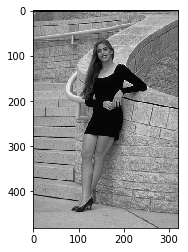

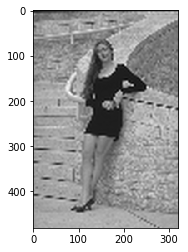

-0.0014351904508719923
-0.002340008297835425


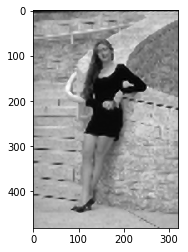

In [ ]:
# trained = load_model(os.getcwd() + "superres.h5")
# im = read_image(images_for_super_resolution()[122],1)
# plt.imshow(im,cmap='gray')
# plt.show()
# corrupted = super_resolution_corruption_with_min(im,4)
# plt.imshow(corrupted,cmap='gray')
# plt.show()
# print(np.mean(im - corrupted))
# new_im = restore_image(corrupted.reshape((corrupted.shape[0],corrupted.shape[1],1)),trained)
# new_im = new_im.reshape((new_im.shape[0],new_im.shape[1]))
# print(np.mean(im - new_im))
# plt.imshow(new_im,cmap='gray')
# plt.show()


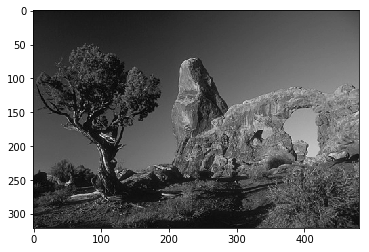

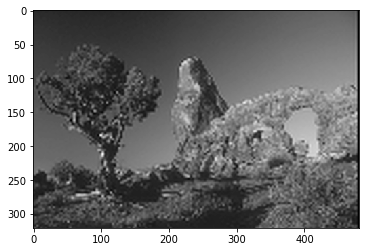

0.0016642126200135025
0.0013236790517762694


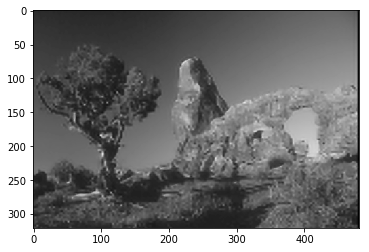

In [ ]:
#  trained = load_model(os.getcwd() + "superres.h5")
# im = read_image(images_for_super_resolution()[0],1)
# plt.imshow(im,cmap='gray')
# plt.show()
# corrupted = super_resolution_corruption_with_min(im,3)
# plt.imshow(corrupted,cmap='gray')
# plt.show()
# print(np.mean(im - corrupted))
# new_im = restore_image(corrupted.reshape((corrupted.shape[0],corrupted.shape[1],1)),trained)
# new_im = new_im.reshape((new_im.shape[0],new_im.shape[1]))
# print(np.mean(im - new_im))
# plt.imshow(new_im,cmap='gray')
# plt.show()

In [ ]:
#@markdown **Question 1:** Give a short description of your implementation and explain why do you think it works and why is it a good method for training the SR task.
Answer1 = "we reduce the image resolution (losing data) and then scale it back up, with a large factor we get pixelated results so the corruption function works well " #@param {type:"string"}
with open(f'answer1.txt', 'w+') as fh:
    fh.write(Answer1)

#@markdown **DON'T FORGET TO RUN THIS CELL AFTER YOU ANSWER IT!**

In [ ]:
#@markdown **Question 2:** Elaborate on the different parameters you've tried to use and how did changing them affect the training process, finally list the parameters you've chosen.
Answer2 = "I first maxed out all the parameters. I noticed that my loss doesn't improve much with more iterations so I've cut the amount of epochs / steps per epoch until I was happy with how the loss changed over training. I eventually ended up with 10 blocks, 10 epochs x iterations per epoch (the function almost converges way before but this has acceptable runtime), batch size 33, patch size 20, 28 channels. The results are all in all decent and don't feel blurry, although small details remain with poor restoration. (I haven't been able to find a configuration that properly cleans small details)." #@param {type:"string"}
with open(f'answer2.txt', 'w+') as fh:
    fh.write(Answer2)

#@markdown **DON'T FORGET TO RUN THIS CELL AFTER YOU ANSWER IT!**

##7.4 Effect of depth
Use the `denoise_num_res_blocks` and `deblur_num_res_blocks` parameters to test models of different depths for the above tasks (only denoising and debluring). Produce a plot of the mean square error on the validation set with respect to the number of residual blocks (from 1 to 5). 

(the $X$ axis should be the number of epochs, the $Y$ axis should be the MSE value, and the graph should have $5$ functions, one for each depth). 

You do not need to submit the function that generates these plots, you should just submit them as part of your final submission.

**Note:** In your submission, the names of the plots should be `depth\_plot\_denoise.png` and  `depth\_plot\_deblur.png` and they should be located in the same directory as the rest of your files.

In [ ]:
#@markdown **Question 3:** Describe the effect of increasing the residual blocks on its performance for each task, both quantitatively in terms of the plot you got and qualitatively in terms of the differences in the image outputs of each model.
Answer3 = "increasing the number of blocks generally speaking improved image quality, in the graph we can see the greatest improvement is moving from 1 to 2 blocks. With more blocks we end in a lower final loss and decline more quickly. In terms of image quality, brightness levels slightly vary between blocks. While results were servable from 1 resblock, more blocks better handled local corruption artifacts. Finally, having more blocks does not always means having a better result - while it had better loss, visually the result of 4 blocks seemed to me subjectively worse than 3/5 blocks. " #@param {type:"string"}
with open(f'answer3.txt', 'w+') as fh:
    fh.write(Answer3)

#@markdown **DON'T FORGET TO RUN THIS CELL AFTER YOU ANSWER IT!**

#6. Bonus (+10): Deep Image Prior
For this section, you should read the article (you can download it from here: [arXiv](https://arxiv.org/abs/1711.10925), and implement the alternative method they propose for image restoration.

Specifically, implement the method described in the sub section titled |"Denoising and generic reconstruction"

In [ ]:
def deep_prior_restore_image(corrupted_image):
    """
    Implementation of the paper on deep prior image restoration for images of size 64x64
    :param corrupted_image: the 64 by 64 corrupted image
    :return: a restored image
    """
    pass

**Note:** In your function you are free to use either the models used in the rest of this assignment or experiment with your own models (or ones suggested in the article). 

Due to computational constraints, you can assume that we will test this function with images which are exactly 64-by-64 pixels. Naturally, due to runtime constraints you might not be able to get to results as good as the ones presented by the authors, however, you should be able to reproduce the underlying effect.



#9. Tips & Guidelines
* For your connivance, some of the functions include "sliders" that let you play with some hyper parameters. If you don't want to use them you are welcome to "override" the values they use and assign values programmatically.  
*   Do not forget to answer **Question 1** and **Question 2** from section 7.3.
*   Do not forget to answer **Question 3** from section 7.4, and to produce the required plots.
*   You are only allowed to use the Tensorflow. Keras framework for implementing neural networks. Do not use ``vanila'' Tensorflow directly. It is okay to use additional functions when implementing the bonus.
*   Be sure to implement quick mode in such a way that testing under this configuration use the exact same methods as the regular mode with the exception of different parameters. We suggest you define the parameters using local variables conditionally on `quick_mode`, and then use them throughout the rest of your learning methods.
*   You may assume **legal input** to all functions.
*   All input images are represented by a matrix of class `np.float64`.
*   Avoid unnecessary loops in your code, e.g. for pixel-wise operations. You can loop over images in a batch in the `load_dataset` function. You can loop over number of residual blocks when building the model.


# 10. Submission
Lucky for us, colab has an easy way of exporting your notebook code to a python file:

Once downloaded, treat your python script the same way you would any other exercise so far.
Submit your exercise via git and ensure that the presubmission script passes succesfully.
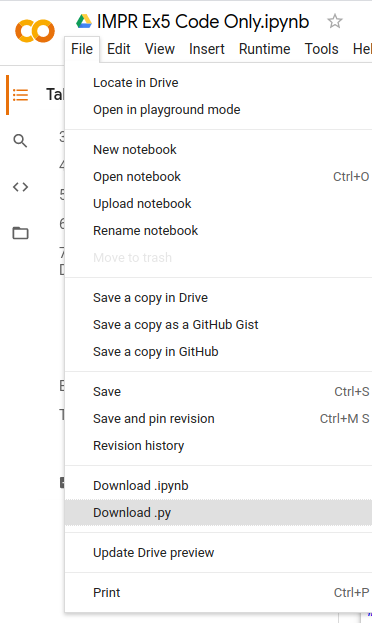

In [ ]:
#@markdown #10.1. Download outputs

#@markdown Playing this cell will create a zip file with your username on it and downloads it.

#@markdown Download your answers and outputs and add them to your git project.
!zip {cs_id}.zip *.png answer*.txt


	zip warning: name not matched: *.png
updating: answer1.txt (deflated 29%)
updating: answer2.txt (deflated 42%)
updating: answer3.txt (deflated 45%)
